<a href="https://colab.research.google.com/github/ananyas713/hypoxemia/blob/master/Get_Feature_Trends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Trend Analysis Notebook
The purpose of this notebook is to analyze feature trends leading to a hypoxemia event. The four main features we are looking at are: mean arterial blood pressure (ABP), peripheral capillary oxygen saturation (SpO2), heart rate (HR), and respiratory rate (Resp). 

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from scipy import stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

dir = '/content/drive/My Drive/College Stuff/Precision Care Medicine/Code and Stuff/Time-series/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
feature = input('Which feature do you want to view? (ABP, SpO2, HR, Resp) ')

Which feature do you want to view? (ABP, SpO2, HR, Resp) ABP


In [ ]:
class Feature_Graph(object):
  
  def read_data(self):
    raise NotImplementedError()

  def analyze_trends(self, p, n):
    #Initialize arrays
    pos = []
    name = []
    pos_list = []

    #Extract starting timepoints
    for j in range(len(p)):
      if (p[j] > 150 and len(pos) < 10000):
        name.append(n[j])
        pos.append(p[j])

    #Create list of 150 min events
    for a in range(len(pos)):
      try:
        pos_list.append(self.data[name[a]][pos[a]-150:pos[a]])
      except:
        continue

    #Find statistics for each timepoint 
    means = []
    sem = []
    std = []
    big_hold = []
    for thing in range(150):
      hold = []
      for thing2 in range(len(pos_list)):
        if (len(pos_list[thing2]) > thing):
          if (pos_list[thing2][thing] < 200):
            hold.append(pos_list[thing2][thing])
      means.append(np.mean(np.asarray(hold)))
      sem.append(stats.sem(np.asarray(hold)))
      std.append(np.std(np.asarray(hold)))
      big_hold.append(np.asarray(hold))

    return means, std, big_hold

  def stat_vals(self):
    #Use Mann-Whitney U test to compare positive and negative distributions for each timepoint
    sigs = []
    for i in range(150):
      p_hold = self.p_bighold[i]
      n_hold = self.n_bighold[i]
      stat, p = stats.mannwhitneyu(p_hold, n_hold)
      if (p < 0.001 and self.p_means[i] < self.n_means[i]):
        sigs.append(-1)
      elif (p < 0.001 and self.p_means[i] > self.n_means[i]):
        sigs.append(1)
      else:
        sigs.append(0)
    return sigs
  
  def plot_trends(self):
    raise NotImplementedError()

  def make_graph(self):
    #Read in data
    self.read_data()
  
    #Read in csv listing positive and negative events
    e = pd.read_csv('/content/drive/My Drive/College Stuff/Precision Care Medicine/Documents/Go_to_publish/event_durations.csv')
    othere = pd.read_csv('/content/drive/My Drive/College Stuff/Precision Care Medicine/Documents/Go_to_publish/training_features/negative.csv')
    
    #Extract event names and positions
    p = np.asarray(e['event_start'])
    ed = np.asarray(e['event_duration'])
    n = np.asarray(e['name'])
    op = np.asarray(othere['position'])
    on = np.asarray(othere['name'])

    #Get trends and stats
    self.p_means, self.p_std, self.p_bighold = self.analyze_trends(p,n)
    self.n_means, self.n_std, self.n_bighold = self.analyze_trends(op,on)
    self.sigs = self.stat_vals()

    #Convert to numpy arrays
    self.n_means = np.asarray(self.n_means)
    self.n_std = np.asarray(self.n_std)
    self.n_bighold = np.asarray(self.n_bighold)
    self.p_means = np.asarray(self.p_means)
    self.p_std = np.asarray(self.p_std)
    self.p_bighold = np.asarray(self.p_bighold)
    self.sigs = np.asarray(self.sigs)
    
    self.plot_trends()

In [ ]:
class SpO2_Graph(Feature_Graph):
  def read_data(self):
    #Read in data
    with open(dir + 'wholeSpO2_clean.json', 'r') as json_file:
      self.data = json.load(json_file)

  def plot_trends(self):
    #Plot means and standard deviations for each timepoint of positive and negative samples
    x = np.linspace(-150,0,150)
    plt.figure(figsize=(7,4))
    plt.rcParams.update({'font.size': 16})
    plt.plot(x, self.n_means, color = 'dodgerblue')
    plt.fill_between(x, self.n_means+self.n_std, self.n_means-self.n_std, color='xkcd:azure', alpha = 0.3)
    plt.plot(x, self.p_means, color = 'tomato')
    plt.fill_between(x, self.p_means+self.p_std, self.p_means-self.p_std, color='xkcd:orange', alpha = 0.3)
    plt.ylabel('SpO2 (%)')
    plt.xlabel('Time Before Event (min)')
    plt.title('SpO2 Trends Averaged Over 10000 Samples')
    plt.legend(['negative', 'positive'])

    plt.figure(figsize=(7,4))
    plt.plot(x, self.sigs)
    plt.ylim(-1.1,1.1)
    plt.ylabel('Sig Diff Btwn Pos and Neg')
    plt.xlabel('Time Before Event (min)')
    plt.title('Significant Difference SpO2')

In [ ]:
class HR_Graph(Feature_Graph):
  def read_data(self):
    #Read in data
    with open(dir + 'HR_clean.json', 'r') as json_file:
      self.data = json.load(json_file)

  def plot_trends(self):
    #Plot means and standard deviations for each timepoint of positive and negative samples
    x = np.linspace(-150,0,150)
    plt.figure(figsize=(7,4))
    plt.rcParams.update({'font.size': 16})
    plt.plot(x, self.n_means, color = 'dodgerblue')
    plt.fill_between(x, self.n_means+self.n_std, self.n_means-self.n_std, color='xkcd:azure', alpha = 0.3)
    plt.plot(x, self.p_means, color = 'tomato')
    plt.fill_between(x, self.p_means+self.p_std, self.p_means-self.p_std, color='xkcd:orange', alpha = 0.3)
    plt.ylabel('HR (bpm)')
    plt.xlabel('Time Before Event (min)')
    plt.title('HR Trends Averaged Over 10000 Samples')
    plt.legend(['negative', 'positive'])

    plt.figure(figsize=(7,4))
    plt.plot(x, self.sigs)
    plt.ylim(-1.1,1.1)
    plt.ylabel('Sig Diff Btwn Pos and Neg')
    plt.xlabel('Time Before Event (min)')
    plt.title('Significant Difference HR')

In [ ]:
class ABP_Graph(Feature_Graph):
  def read_data(self):
    #Read in data
    with open(dir + 'ABPMean_clean.json', 'r') as json_file:
      self.data = json.load(json_file)

  def plot_trends(self):
    #Plot means and standard deviations for each timepoint of positive and negative samples
    x = np.linspace(-150,0,150)
    plt.figure(figsize=(7,4))
    plt.rcParams.update({'font.size': 16})
    plt.plot(x, self.n_means, color = 'dodgerblue')
    plt.fill_between(x, self.n_means+self.n_std, self.n_means-self.n_std, color='xkcd:azure', alpha = 0.3)
    plt.plot(x, self.p_means, color = 'tomato')
    plt.fill_between(x, self.p_means+self.p_std, self.p_means-self.p_std, color='xkcd:orange', alpha = 0.3)
    plt.ylabel('Mean ABP (mmHg)')
    plt.xlabel('Time Before Event (min)')
    plt.title('Mean ABP Trends Averaged Over 10000 Samples')
    plt.legend(['negative', 'positive'])

    plt.figure(figsize=(7,4))
    plt.plot(x, self.sigs)
    plt.ylim(-1.1,1.1)
    plt.ylabel('Sig Diff Btwn Pos and Neg')
    plt.xlabel('Time Before Event (min)')
    plt.title('Significant Difference Mean ABP')

In [ ]:
class Resp_Graph(Feature_Graph):
  def read_data(self):
    #Read in data
    with open(dir + 'RESP_clean.json', 'r') as json_file:
      self.data = json.load(json_file)

  def plot_trends(self):
    #Plot means and standard deviations for each timepoint of positive and negative samples
    x = np.linspace(-150,0,150)
    plt.figure(figsize=(7,4))
    plt.rcParams.update({'font.size': 16})
    plt.plot(x, self.n_means, color = 'dodgerblue')
    plt.fill_between(x, self.n_means+self.n_std, self.n_means-self.n_std, color='xkcd:azure', alpha = 0.3)
    plt.plot(x, self.p_means, color = 'tomato')
    plt.fill_between(x, self.p_means+self.p_std, self.p_means-self.p_std, color='xkcd:orange', alpha = 0.3)
    plt.ylabel('Resp Rate (breaths per min)')
    plt.xlabel('Time Before Event (min)')
    plt.title('Resp Rate Trends Averaged Over 10000 Samples')
    plt.legend(['negative', 'positive'])

    plt.figure(figsize=(7,4))
    plt.plot(x, self.sigs)
    plt.ylim(-1.1,1.1)
    plt.ylabel('Sig Diff Btwn Pos and Neg')
    plt.xlabel('Time Before Event (min)')
    plt.title('Significant Difference Resp')

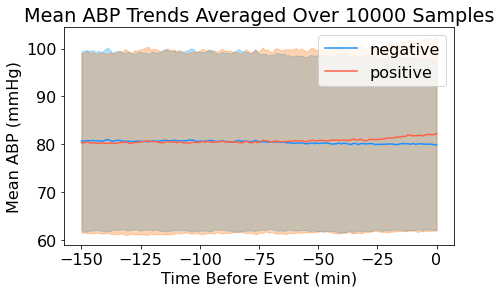

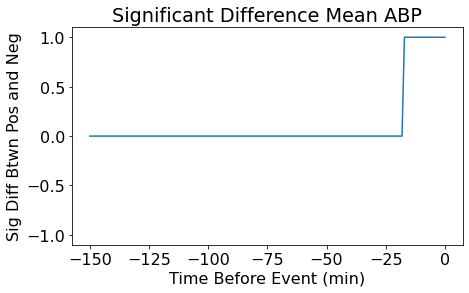

In [ ]:
if feature == 'SpO2':
  feat_graph = SpO2_Graph()
elif feature == 'HR':
  feat_graph = HR_Graph()
elif feature == 'ABP':
  feat_graph = ABP_Graph()
elif feature == 'Resp':
  feat_graph = Resp_Graph()
else:
  raise ValueError('Not a recognized feature')

feat_graph.make_graph()

### Plot explanations
The top graph shows the feature trend 150 minutes leading up to a hypoxemia event (positive^) or no event (negative^). The time point 0 indicates the start of the event. The shaded regions indicate the standard deviations.

The bottom graph shows whether the positive and negative trends are significantly different (p < 0.001 using a Mann-Whitney U test). A value of 0 means no significant difference, a value of 1 means that the positive^ values are significantly greater than the negative^ values, and a value of -1 means that the negative^ values are significantly greater than the positive^ values. 